# Model skill assessment for regression

FMSkill is a general purpose model skill assessment library for (spatio)/temporal data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

To illustrate the functionality we will use synthetic data.

In [2]:
def true_function(x1, x2):
    l = np.clip(x2, 0.01, None)
    return 1 / (1 + np.exp(-x1/l))

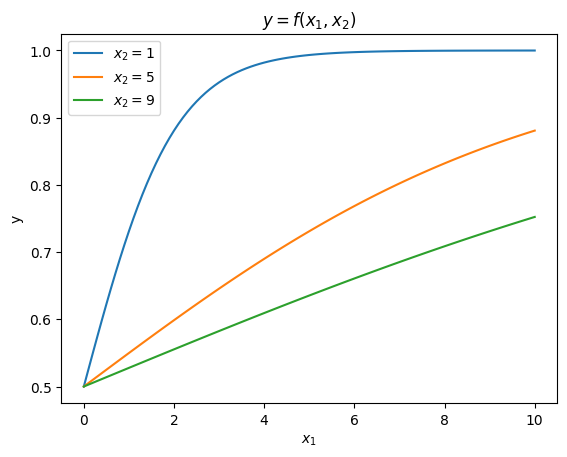

In [27]:
x1 = np.linspace(0,10, 101)
plt.plot(x1, true_function(x1, 1), label='$x_2=1$')
plt.plot(x1, true_function(x1, 5), label='$x_2=5$')
plt.plot(x1, true_function(x1, 9), label='$x_2=9$')
plt.legend();
plt.xlabel('$x_1$');
plt.ylabel('y');
plt.title('$y = f(x_1, x_2)$');

In [4]:
def generate_data(n_samples=1000, noise=0.1):
    x1 = np.random.uniform(0, 10, n_samples)
    x2 = np.random.uniform(0, 10, n_samples)
    y = true_function(x1, x2) + np.random.normal(0, noise, n_samples)
    X = np.vstack([x1, x2]).T
    return X, y

In [5]:
X, y = generate_data(noise=0.01)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr =lr_model.predict(X_test)


poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)


rf_model = RandomForestRegressor(n_estimators=10) # only 10 trees for demonstration purposes
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [7]:
df = pd.DataFrame({'true':y_test,
                    'linear': y_pred_lr,
                    'quadratic': y_pred_poly,
                    'rf' : y_pred_rf})

# add a datetime index
df.index = pd.date_range('2019-01-01', periods=len(df), freq='H')
df.head()

,true,linear,quadratic,rf
2019-01-01 00:00:00,0.520883,0.602069,0.521606,0.501344
2019-01-01 01:00:00,0.578679,0.606875,0.569997,0.578573
2019-01-01 02:00:00,0.737849,0.758357,0.754563,0.746082
2019-01-01 03:00:00,0.654700,0.691211,0.680736,0.658367
2019-01-01 04:00:00,0.770186,0.792287,0.770215,0.751579


In [8]:
import fmskill

cmp = fmskill.from_matched(df, obs_item='true') # TODO add quantity 
cmp

<Comparer>
Observation: true, n_points=250
 Model: linear, rmse=0.053
 Model: quadratic, rmse=0.035
 Model: rf, rmse=0.014

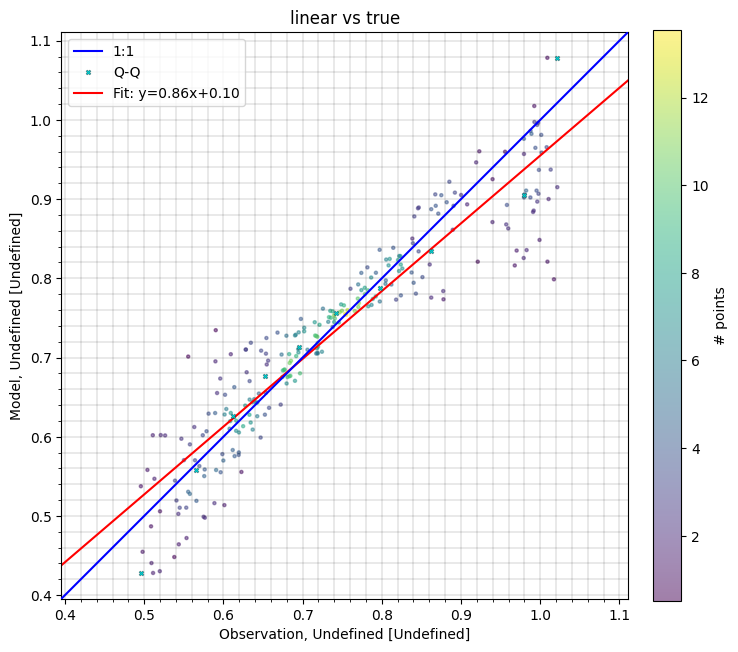

In [9]:
cmp.sel(model='linear').scatter();

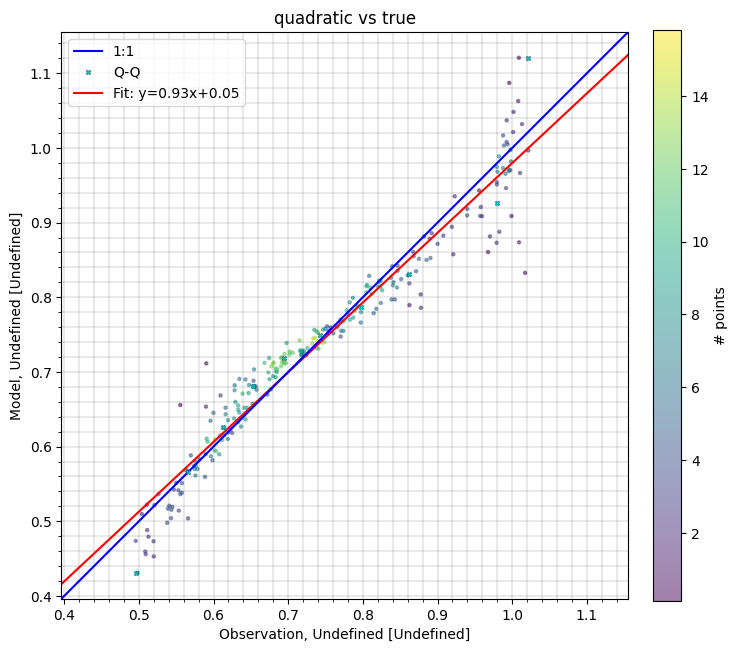

In [13]:
cmp.sel(model='quadratic').scatter();

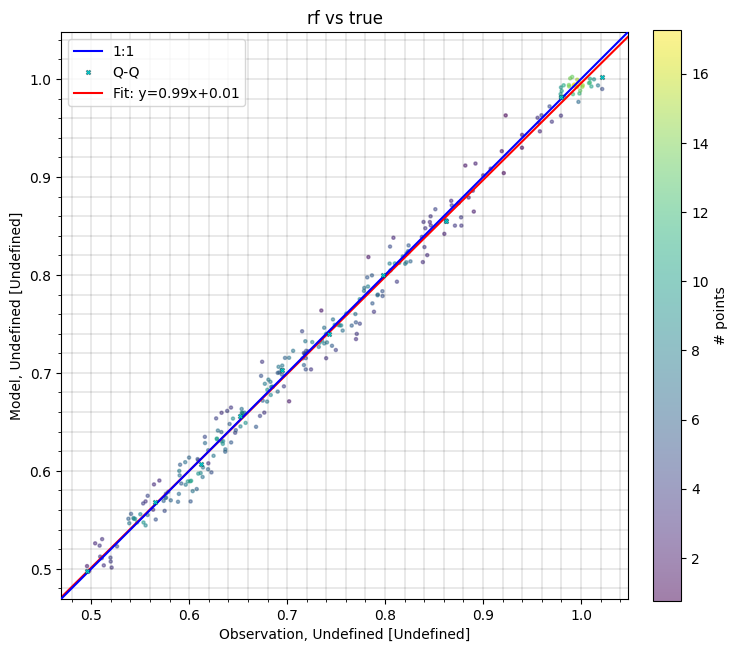

In [10]:
cmp.sel(model='rf').scatter();

In [18]:
cmp.skill().round(2)

,observation,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,,
linear,true,250,-0.01,0.05,0.05,0.04,0.93,0.07,0.87
quadratic,true,250,-0.00,0.04,0.04,0.02,0.97,0.05,0.94
rf,true,250,-0.00,0.01,0.01,0.01,1.00,0.02,0.99


Compare skill table with scores from scikit-learn

In [19]:
print(f'Linear: {lr_model.score(X_test, y_test):.2f}')
print(f'Quadratic: {poly_model.score(X_test, y_test):.2f}')
print(f'Random Forest: {rf_model.score(X_test, y_test):.2f}')

Linear: 0.87
Quadratic: 0.94
Random Forest: 0.99


In [21]:
cmp.plot_timeseries(backend="plotly");